## Day 32 Lecture 1 Assignment

In this assignment, we will learn about K nearest neighbor regression. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

The meaning of the different columns can be found here: https://www.kaggle.com/tonypriyanka2913/employee-absenteeism

0. ID **(categorical)** **DROP**
1. Reason for absence **(categorical)**
2. Month of absence **(categorical)**
3. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6)) **(categorical)**
4. Seasons (summer (1), autumn (2), winter (3), spring (4)) **(categorical)**
5. Transportation expense
6. Distance from Residence to Work (kilometers)
7. Service time
8. Age
9. Work load Average/day
10. Hit target
11. Disciplinary failure (yes=1; no=0) **(categorical)**
12. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4)) **(categorical)**
13. Son (number of children)
14. Social drinker (yes=1; no=0) **(categorical)**
15. Social smoker (yes=1; no=0) **(categorical)**
16. Pet (number of pet)
17. Weight
18. Height
19. Body mass index
20. Absenteeism time in hours **(target)**

In [55]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [56]:
absent = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv', sep=';')

In [57]:
absent.info()
absent.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

(740, 21)

In [58]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


Find which variables have the highest pairwise correlation and remove them from our dataset. Additionally, try to think of which variables are correlated by looking at the column names and remove those columns as well.

Note: When choosing between two categorical variables that are correlated, you often want to keep the one with fewer unique values. Why might that be? (Think about the cons of KNN.)

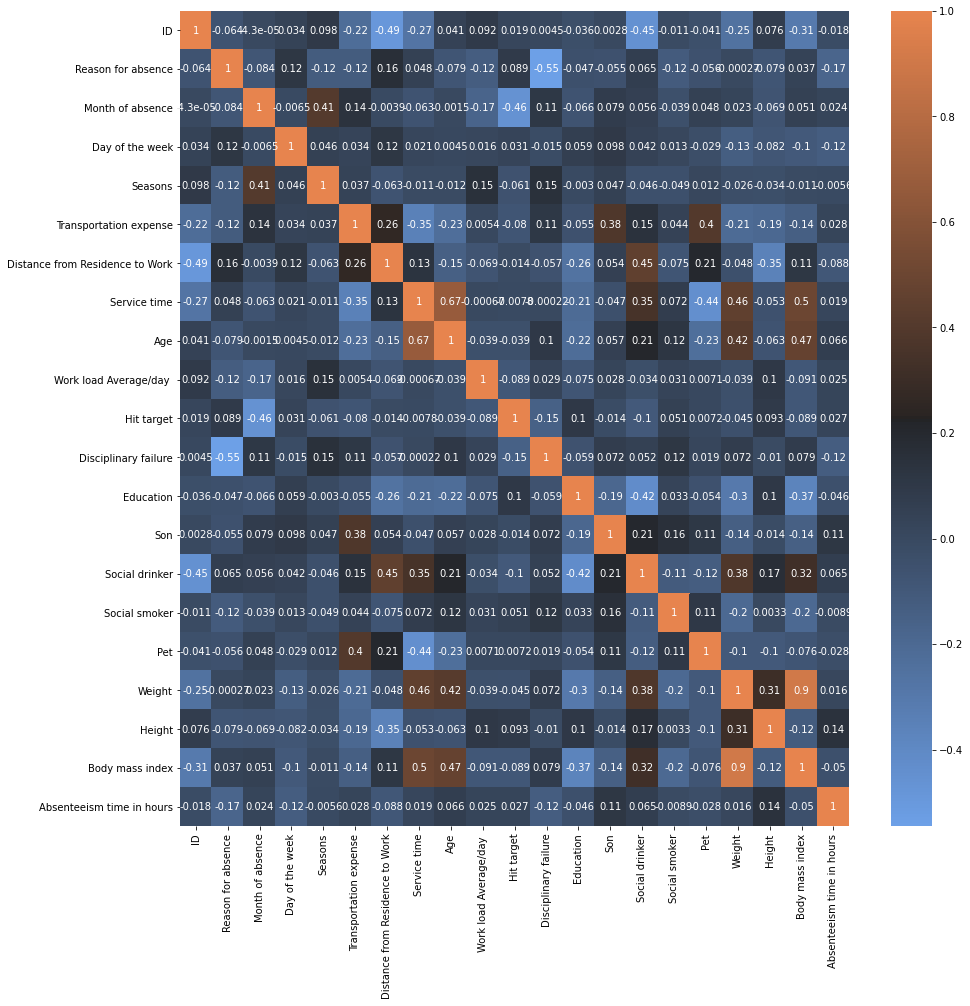

In [63]:
# answer below:
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(absent.corr(), annot=True, cmap=cmap)
plt.show()

In [60]:
corr_melt = pd.melt(absent.corr())
corr_melt = corr_melt[corr_melt['value'] < 1.0]
corr_melt['value'] = np.abs(corr_melt['value'])
corr_melt.sort_values('value', ascending=False).head(20)

,variable,value
416,Body mass index,0.904117
376,Weight,0.904117
155,Service time,0.670979
175,Age,0.670979
32,Reason for absence,0.545054
232,Disciplinary failure,0.545054
166,Service time,0.499718
406,Body mass index,0.499718
6,ID,0.486160
126,Distance from Residence to Work,0.486160


In [7]:
absent[['Weight', 'Body mass index']].nunique()

Weight             26
Body mass index    17
dtype: int64

In [8]:
absent.drop('Weight', 1, inplace=True)

Figure out which columns actually contain sneaky categorical variables and turn those into dummy variables.

In [9]:
# answer below:
absent.drop('ID', 1, inplace=True)

In [10]:
absent['Reason for absence'].value_counts()

23    149
28    112
27     69
13     55
0      43
19     40
22     38
26     33
25     31
11     26
10     25
18     21
14     19
1      16
7      15
6       8
12      8
8       6
21      6
9       4
5       3
24      3
16      3
4       2
15      2
3       1
2       1
17      1
Name: Reason for absence, dtype: int64

In [11]:
absent['Reason_groups'] = np.where(absent['Reason for absence'] == 0, 'Disciplinary', 
                                   np.where(absent['Reason for absence'] < 15, 'Disease',
                                   np.where(absent['Reason for absence'] < 22, 'Not_Disease', 'Other')))


In [12]:
absent['Reason_groups'].value_counts()

Other           435
Disease         189
Not_Disease      73
Disciplinary     43
Name: Reason_groups, dtype: int64

In [13]:
absent = pd.concat([absent,
                    pd.get_dummies(absent['Reason_groups'], prefix='Reason', drop_first=True)],
                   axis = 1)
absent.drop(['Reason for absence', 'Reason_groups'], 1, inplace=True)

In [14]:
absent['Month of absence'].value_counts()

3     87
2     72
10    71
7     67
5     64
11    63
8     54
6     54
9     53
4     53
1     50
12    49
0      3
Name: Month of absence, dtype: int64

In [15]:
absent = absent.loc[absent['Month of absence'] != 0]

absent['Month of absence'].value_counts()

3     87
2     72
10    71
7     67
5     64
11    63
8     54
6     54
9     53
4     53
1     50
12    49
Name: Month of absence, dtype: int64

In [16]:
# absent = pd.concat([absent,
#                     pd.get_dummies(absent['Month of absence'], prefix='Month', drop_first=True)],
#                    axis = 1)

absent.drop('Month of absence', 1, inplace=True)

In [17]:
absent['Seasons'].value_counts()

4    195
2    191
3    182
1    169
Name: Seasons, dtype: int64

In [18]:
absent = pd.concat([absent,
                    pd.get_dummies(absent['Seasons'], prefix='Season', drop_first=True)],
                   axis = 1)

absent.drop('Seasons', 1, inplace=True)

In [19]:
absent['Day of the week'].value_counts()

2    161
4    155
3    153
6    143
5    125
Name: Day of the week, dtype: int64

In [20]:
absent = pd.concat([absent,
                    pd.get_dummies(absent['Day of the week'], prefix='Day', drop_first=True)],
                   axis = 1)

absent.drop('Day of the week', 1, inplace=True)

In [21]:
absent['Disciplinary failure'].value_counts()

0    697
1     40
Name: Disciplinary failure, dtype: int64

In [22]:
absent.drop('Disciplinary failure', 1, inplace=True)

In [23]:
absent['Education'].value_counts()

1    608
3     79
2     46
4      4
Name: Education, dtype: int64

In [24]:
absent = pd.concat([absent,
                    pd.get_dummies(absent['Education'], prefix='Education', drop_first=True)],
                   axis = 1)

absent.drop('Education', 1, inplace=True)

absent.head()

,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Social drinker,Social smoker,Pet,Height,Body mass index,Absenteeism time in hours,Reason_Disease,Reason_Not_Disease,Reason_Other,Season_2,Season_3,Season_4,Day_3,Day_4,Day_5,Day_6,Education_2,Education_3,Education_4
0,289,36,13,33,239.554,97,2,1,0,1,172,30,4,0,0,1,0,0,0,1,0,0,0,0,0,0
1,118,13,18,50,239.554,97,1,1,0,0,178,31,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,179,51,18,38,239.554,97,0,1,0,0,170,31,2,0,0,1,0,0,0,0,1,0,0,0,0,0
3,279,5,14,39,239.554,97,2,1,1,0,168,24,4,1,0,0,0,0,0,0,0,1,0,0,0,0
4,289,36,13,33,239.554,97,2,1,0,1,172,30,2,0,0,1,0,0,0,0,0,1,0,0,0,0


In [25]:
y = absent['Absenteeism time in hours']
X = absent.drop('Absenteeism time in hours', 1)

In [26]:
X_vif = X.copy()
X_vif = sm.add_constant(X_vif)

vif = pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
          index=X_vif.columns)
print(vif.sort_values(ascending=False))

const                              2785.240961
Reason_Other                          5.488091
Reason_Disease                        4.681869
Service time                          3.417859
Reason_Not_Disease                    2.766115
Social drinker                        2.739695
Distance from Residence to Work       2.664470
Age                                   2.587248
Season_2                              2.241515
Season_3                              2.065242
Body mass index                       1.982407
Pet                                   1.911791
Height                                1.848771
Transportation expense                1.840701
Season_4                              1.717166
Day_6                                 1.663582
Day_3                                 1.616447
Day_4                                 1.584575
Education_3                           1.556351
Hit target                            1.535309
Day_5                                 1.514137
Son          

Split the data into train and test with test containing 20% of the data, then scale your features.

In [27]:
# answer below:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)


Train a series of KNN regression models with a range of K values. For each K value, use cross validation of the training set and find the average RMSE score. Make a plot of K versus average RMSE. What is the best value of K?

In [42]:
# answer below
k_list = range(1,152,1)
avg_RMSE = []
train_errors = []
test_errors = []
train_scores = []
test_scores = []
for k in k_list:
  knn_reg = KNeighborsRegressor(n_neighbors=k)
  cv = cross_val_score(knn_reg, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
  avg_RMSE.append(np.mean(np.abs(cv)))
  knn_reg.fit(X_train_scaled, y_train)
  y_pred_train = knn_reg.predict(X_train_scaled)
  y_pred_test = knn_reg.predict(X_test_scaled)
  train_errors.append(mean_squared_error(y_train, y_pred_train, squared=False))
  test_errors.append(mean_squared_error(y_test, y_pred_test, squared=False))
  train_scores.append(knn_reg.score(X_train_scaled, y_train))
  test_scores.append(knn_reg.score(X_test_scaled, y_test))

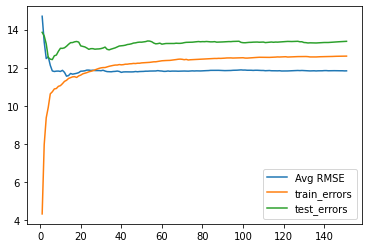

In [52]:
plt.plot(k_list, avg_RMSE, label='Avg RMSE')
plt.plot(k_list, train_errors, label='train_errors')
plt.plot(k_list, test_errors, label='test_errors')
plt.legend()
plt.show()

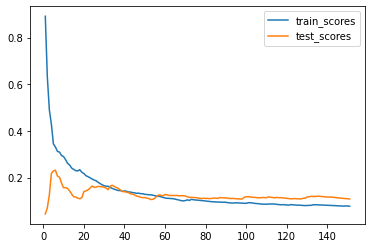

In [44]:
plt.plot(k_list, train_scores, label='train_scores')
plt.plot(k_list, test_scores, label='test_scores')
plt.legend()
plt.show()

In [45]:
knn_reg = KNeighborsRegressor()
params = {'n_neighbors': k_list}

knn_grid = GridSearchCV(knn_reg, param_grid = params, cv=5, scoring='neg_root_mean_squared_error')

knn_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 152)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [46]:
knn_grid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')

Using your best K, fit a model to all your training data and show the RMSE for the training and testing sets.

In [47]:
# answer below
# knn_reg = KNeighborsRegressor(n_neighbors=15)
# knn_reg.fit(X_train_scaled, y_train)

y_pred_train = knn_grid.predict(X_train_scaled)
y_pred_test = knn_grid.predict(X_test_scaled)
print(f'RMSE Training: {mean_squared_error(y_train, y_pred_train, squared=False)}')
print(f'RMSE Test: {mean_squared_error(y_test, y_pred_test, squared=False)}')


RMSE Training: 11.33777634022851
RMSE Test: 13.12423567794245


In [48]:
print(f'Training Score: {r2_score(y_train, y_pred_train)}')
print(f'Test Score: {r2_score(y_test, y_pred_test)}')

Training Score: 0.25347718882537784
Test Score: 0.1423203377509884


Create a homoscedasticity plot (also called residual plot). How is your model performing? What ideas do you have to improve the model?

In [49]:
# answer below
residuals_training = np.array(y_pred_train) - np.array(y_train)
np.mean(residuals_training)

-0.09755779025728101

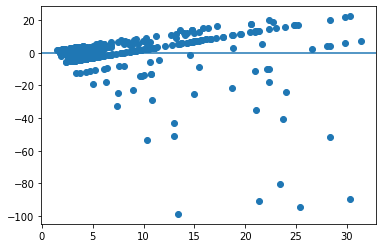

In [50]:
plt.scatter(y_pred_train, residuals_training)
plt.axhline(y=0)
plt.show()

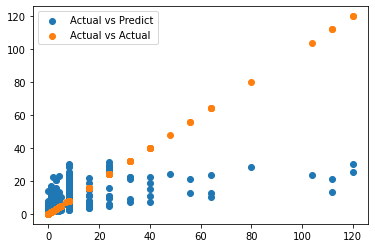

In [51]:
plt.scatter(y_train, y_pred_train, label='Actual vs Predict')
plt.scatter(y_train, y_train, label='Actual vs Actual')
plt.legend()
plt.show()